In [1]:
%load_ext tensorboard.notebook 

In [2]:
!rm -rf ./logs/ 

In [3]:
import datetime
import tensorflow as tf

# Параметры для плагина с отбором гиперпараметров
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
from google.protobuf import struct_pb2

In [4]:
from matplotlib.pylab import plt
%matplotlib inline

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4423680/4422102 [==============================] - 2s 0us/step


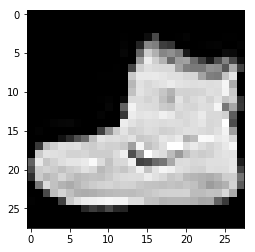

In [7]:
plt.imshow(x_train[0],cmap='gray')

In [8]:
num_units_list = [16, 32]
dropout_rate_list = [0.1, 0.2] 
optimizer_list = ['adam', 'sgd'] 

In [9]:
def create_experiment_summary(num_units_list, dropout_rate_list, optimizer_list):
    num_units_list_val = struct_pb2.ListValue()
    num_units_list_val.extend(num_units_list)
    dropout_rate_list_val = struct_pb2.ListValue()
    dropout_rate_list_val.extend(dropout_rate_list)
    optimizer_list_val = struct_pb2.ListValue()
    optimizer_list_val.extend(optimizer_list)
    return hparams_summary.experiment_pb(
      # The hyperparameters being changed
            hparam_infos=[
                  api_pb2.HParamInfo(name='num_units',
                                     display_name='Number of units',
                                     type=api_pb2.DATA_TYPE_FLOAT64,
                                     domain_discrete=num_units_list_val),
                  api_pb2.HParamInfo(name='dropout_rate',
                                     display_name='Dropout rate',
                                     type=api_pb2.DATA_TYPE_FLOAT64,
                                     domain_discrete=dropout_rate_list_val),
                  api_pb2.HParamInfo(name='optimizer',
                                     display_name='Optimizer',
                                     type=api_pb2.DATA_TYPE_STRING,
                                     domain_discrete=optimizer_list_val)
              ],
              # The metrics being tracked
              metric_infos=[
                  api_pb2.MetricInfo(
                      name=api_pb2.MetricName(
                          tag='accuracy'),
                      display_name='Accuracy'),
              ]
          )

exp_summary = create_experiment_summary(num_units_list, dropout_rate_list, optimizer_list)
root_logdir_writer = tf.summary.create_file_writer("logs/hparam_tuning")
with root_logdir_writer.as_default():
    tf.summary.import_event(tf.compat.v1.Event(summary=exp_summary).SerializeToString())

AttributeError: module 'tensorflow._api.v1.summary' has no attribute 'create_file_writer'

In [10]:
def train_test_model(hparams):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams['num_units'], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams['dropout_rate']),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
      ])
    model.compile(optimizer=hparams['optimizer'],
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [11]:
def run(run_dir, hparams):
    writer = tf.summary.create_file_writer(run_dir)
    summary_start = hparams_summary.session_start_pb(hparams=hparams)

    with writer.as_default():
        accuracy = train_test_model(hparams)
        summary_end = hparams_summary.session_end_pb(api_pb2.STATUS_SUCCESS)

        tf.summary.scalar('accuracy', accuracy, step=1, description="The accuracy")
        tf.summary.import_event(tf.compat.v1.Event(summary=summary_start).SerializeToString())
        tf.summary.import_event(tf.compat.v1.Event(summary=summary_end).SerializeToString())

In [12]:
session_num = 0

for num_units in num_units_list:
    for dropout_rate in dropout_rate_list:
        for optimizer in optimizer_list:
            hparams = {'num_units': num_units, 'dropout_rate': dropout_rate, 'optimizer': optimizer}
            print('--- Running training session %d' % (session_num + 1))
            print(hparams)
            run_name = "run-%d" % session_num
            run("logs/hparam_tuning/" + run_name, hparams)
            session_num += 1

--- Running training session 1
{'num_units': 16, 'dropout_rate': 0.1, 'optimizer': 'adam'}


AttributeError: module 'tensorflow._api.v1.summary' has no attribute 'create_file_writer'

In [14]:
%tensorboard --logdir logs/hparam_tuning

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# https://www.tensorflow.org/tensorboard/r2/hyperparameter_tuning_with_hparams

In [ ]:
# Простой пример :

In [26]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))

# initiate RMSprop optimizer
opt = tf.keras.optimizers.Adam()

    # Let's train the model using RMSprop
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.fit(x_train,y_train,epochs=10,batch_size=256,validation_data=(x_test,y_test))

ValueError: Input 0 of layer conv2d is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 28, 28]